<a href="https://colab.research.google.com/github/reetika-goel/Emerging-Technologies/blob/master/Dogs_vs_Cat_LeNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Import Libraries**

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications import VGG16
from keras.models import Model
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
#!ls
#os.getcwd()                    #To check if image was uploaded or not

print(os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset"))

Using TensorFlow backend.


['train', 'test1']


In [4]:
#Reading the filenames from the directory

filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('dog')
    else:
        categories.append('cat')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df.head()

,filename,category
0,cat.4952.jpg,cat
1,cat.3783.jpg,cat
2,dog.10199.jpg,dog
3,dog.7919.jpg,dog
4,dog.9934.jpg,dog


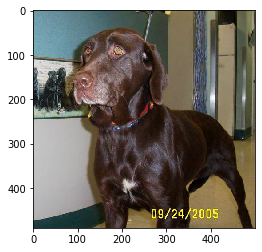

In [5]:
sample = random.choice(filenames)
image = load_img("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/"+sample)
plt.imshow(image)

#**Build Model**

**LeNet**

The LeNet architecture is an excellent grassroots architecture that is both small enough to run on your system and large enough to provide interesting and robust results, especially for digit classification problems. The network was conceptualized by Yann LeCunn in his 1998 paper, [Gradient-Based Learning Applied to Document Recognition](https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

It's architecture consists of 2 sets of Convolutional Layer => Max Pool Layer, followed by a Hidden Layer that is finally fed into a Softmax classifier.

In [0]:
class LeNet:

    def build(width, height, depth, classes):
    
        model = Sequential()
        inputShape = (height, width, depth)

        model.add(Conv2D(20, 5, padding="same",
                         input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        model.add(Conv2D(50, 5, padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

#**Prepare Test and Train Data**

In [0]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()

# validate_df = validate_df.sample(n=100).reset_index() # use for fast testing code purpose
# train_df = train_df.sample(n=1800).reset_index() # use for fast testing code purpose

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [18]:
image_size = 150
input_shape = (image_size, image_size, 3)
epochs = 10
batch_size = 16

model = LeNet.build(width=150, height=150, depth=3, classes=1)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 150, 150, 20)      1520      
_________________________________________________________________
activation_9 (Activation)    (None, 150, 150, 20)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 75, 75, 20)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 50)        25050     
_________________________________________________________________
activation_10 (Activation)   (None, 75, 75, 50)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 37, 37, 50)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 68450)            

#**Training Generator**

In [19]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22509 validated image filenames belonging to 2 classes.


#**Validation Generator**

In [20]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 2501 validated image filenames belonging to 2 classes.


#**Fit Model**

In [21]:
# fine-tune the model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

Epoch 1/10





1406/1406 [==============================] - 11440s 8s/step - loss: 7.9722 - acc: 0.4999 - val_loss: 7.9776 - val_acc: 0.4996
Epoch 2/10
1406/1406 [==============================] - 292s 208ms/step - loss: 7.9718 - acc: 0.5000 - val_loss: 7.9744 - val_acc: 0.4998
Epoch 3/10
1406/1406 [==============================] - 289s 205ms/step - loss: 7.9734 - acc: 0.4999 - val_loss: 7.9808 - val_acc: 0.4994
Epoch 4/10
1406/1406 [==============================] - 291s 207ms/step - loss: 7.9704 - acc: 0.5000 - val_loss: 7.9808 - val_acc: 0.4994
Epoch 5/10
1406/1406 [==============================] - 291s 207ms/step - loss: 7.9722 - acc: 0.4999 - val_loss: 7.9487 - val_acc: 0.5014
Epoch 6/10
1406/1406 [==============================] - 292s 207ms/step - loss: 7.9685 - acc: 0.5002 - val_loss: 7.9423 - val_acc: 0.5018
Epoch 7/10
1406/1406 [==============================] - 292s 208ms/step - loss: 7.9788 - acc: 0.4995 - val_loss: 8.0386 - val_acc: 0.4958
Epoch 8/10
1406/1406 [========

In [22]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.500000  ;  loss = 7.971193 


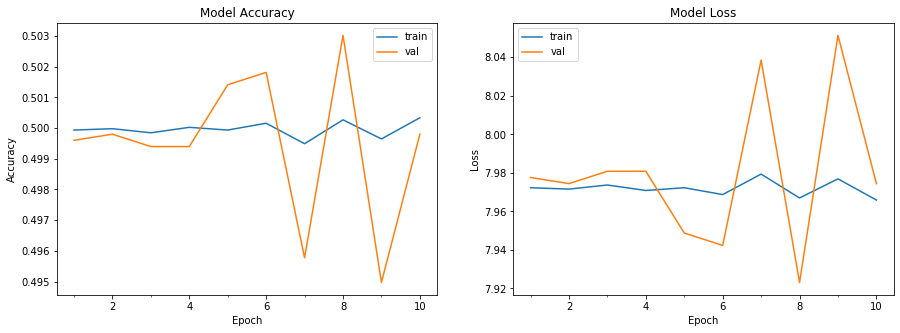

In [23]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[acc])+1),len(model_history.history[acc])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [0]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

In [0]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 'dog', 'cat')

In [26]:
y_final.size

2501

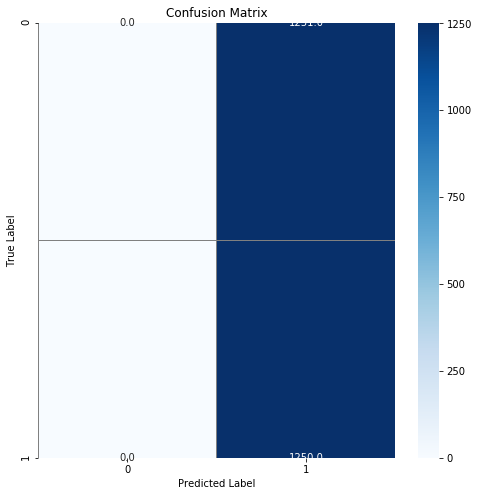

In [27]:
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Blues",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['cat','dog'])

print(report)

              precision    recall  f1-score   support

         cat       0.00      0.00      0.00      1251
         dog       0.50      1.00      0.67      1250

    accuracy                           0.50      2501
   macro avg       0.25      0.50      0.33      2501
weighted avg       0.25      0.50      0.33      2501



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#**Prepare Testing Data**

In [0]:
test_filenames = os.listdir("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#**Create Testing Generator**

In [30]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


#**Predict**

In [0]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 'dog', 'cat')

##**See Predicted Results**

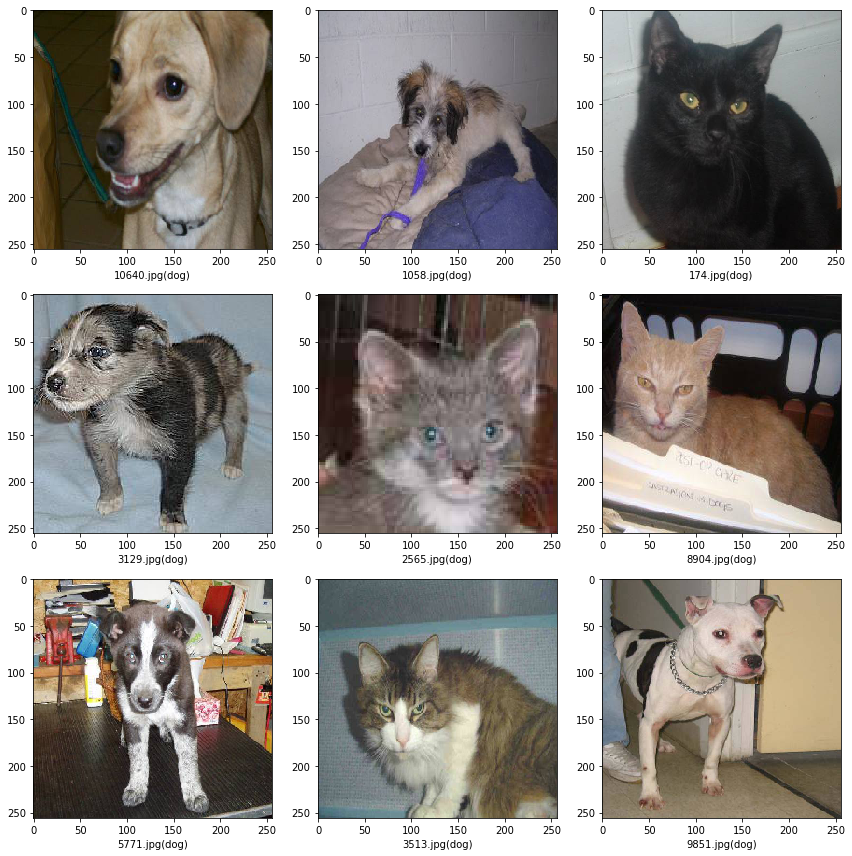

In [32]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/drive/My Drive/Colab Notebooks/Dogs_vs_Cat_dataset/test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

#**Submission**

Text(0.5, 1.0, '(Test data)')

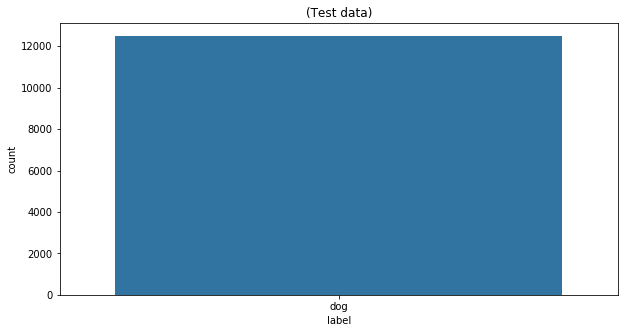

In [33]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

plt.figure(figsize=(10,5))
sns.countplot(submission_df['label'])
plt.title("(Test data)")